In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [3]:
import ncut_loss
import build_Unet
import build_Wnet
import getData

In [4]:
bool(0)

False

# DATA

In [4]:
#dataset_parts = Dataset.from_coco('/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_train.json')
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"]    
#dataset_filtered = dataset_parts.filter_images_with_cats(keep=to_keep).filter_cats(keep=to_keep)



In [5]:
path = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_val.json'
gen_non_damaged = getData.get_generator(path,128,3,to_keep)

231

In [61]:
img = gen.load_image([1,0])

In [62]:
imds

ImageDataset(
    path='/home/ubuntu/data/drivy/images/without_event/026/4460107_checkout_6.jpg',
    anns#COUNT={'polygons': 3, 'bboxes': 0},
    tags=[],
    idx=1,)
# Image size: (1600, 1200)
# Vehicle bbox: BBox(xyxy=[0.0, 0.0, 1598.5, 1112.6721801757812], label='vehicle', image_size=(1600, 1200), attributes={})
# EXIF orientation: 0


interactive(children=(Checkbox(value=False, description='show_polygons'), Output()), _dom_classes=('widget-int…

In [63]:
img.shape

(128, 128, 3)

In [64]:
def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )

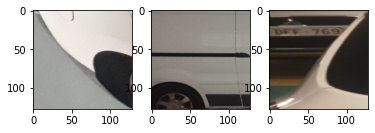

In [70]:
items = gen.__getitem__(np.random.randint(0,100))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(rescale(items[0].numpy()))
plt.subplot(1,3,2)
plt.imshow(rescale(items[1].numpy()))
plt.subplot(1,3,3)
plt.imshow(rescale(items[2].numpy()))


In [71]:
img_crop = gen.__getitem__(0)

# MODEL

In [73]:
neighbor_filter=ncut_loss.neighbor_filter((128,128))

In [98]:
encoder = build_Unet.build_Unet(K=15,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
decoder = build_Unet.build_Unet(K=15,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
wn = build_Wnet.Wnet(encoder,decoder,(128,128))

def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [111]:
im  = tf.expand_dims(items[0],0)
wn.loss_fn_reconstruction(im,wn(im))

<tf.Tensor: shape=(), dtype=float32, numpy=0.32455447>

In [113]:
21104.156/0.32455447

65025.004893631565

In [114]:
255*255

65025

In [99]:
def visualise_seg(image,encoder):
    image = tf.expand_dims(image, 0)
    seg = encoder(image)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
    loss = ncut_loss.compute_soft_ncuts(image,seg,neighbor_filter)
    res = wn(image).numpy()[0]
    res = rescale(res)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(ag[0])
    plt.subplot(1,2,2)
    plt.imshow(res)
    print(loss)

tf.Tensor(13.333407, shape=(), dtype=float32)


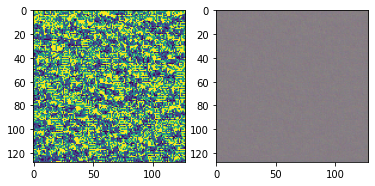

In [100]:
visualise_seg(gen.__getitem__(300)[0],wn.encoder)


In [101]:
wn.encoder.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 128, 128, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 128, 128, 64) 256         conv2d_190[0][0]                 
__________________________________________________________________________________________________
re_lu_180 (ReLU)                (None, 128, 128, 64) 0           batch_normalization_180[0][0]    
______________________________________________________________________________________

In [ ]:
seg = encoder(image_ref)
ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)[0]
ag = ag.numpy()
ag = ag *255 /ag.max()
print(ag.shape)
plt.imshow(ag)

In [ ]:
seg = encoder(image_ref)
ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)[0]
ag = ag.numpy()
ag = ag *255 /ag.max()
print(ag.shape)
plt.imshow(ag)

In [ ]:
def set_learning_rate(step_counter,model,base_lr):
    if(step_counter>=1000):
        new_lr = base_lr/(10**(step_counter//1000))
    else:
        new_lr = base_lr
    model.optimizer.lr = new_lr
    
def training(model,train_dataset,epochs,start_epoch,base_lr,ckpt_freq,ckpt_dir_path,log_dir_path,img_dir_path,image_ref):
  
    step_counter=0
    writer = tf.summary.create_file_writer(log_dir_path)
    
    print(epochs)
    print(start_epoch)
    
    for epoch in range(start_epoch,epochs):
        set_learning_rate(epoch,model,base_lr)

        print("\nStart of epoch %d" % (epoch,))
        print("Learning rate" +str(model.optimizer.lr))



        ##TRAIN
        total_train_loss_encoder = []
        total_train_loss_decoder = []

        for step, x_batch_train in enumerate(train_dataset):
            step_counter+=1
            set_learning_rate(step_counter,model,base_lr)

            train_losses = model.train_step(x_batch_train)

            train_losses_encoder=train_losses["loss_encoder"]
            train_losses_decoder=train_losses["loss_decoder"]

            total_train_loss_encoder.append(train_losses_encoder.numpy())
            total_train_loss_decoder.append(train_losses_decoder.numpy())

            if step_counter%ckpt_freq ==0:
                ckpt_name="ckpt"+str(step_counter)
                model.save_weights(ckpt_dir_path)
            if step_counter%1==0:
                print("step "+str(step) ) 
                print('enc loss ',train_losses_encoder)
                print('dec loss ' ,train_losses_decoder)

            if step_counter%50==0:
                res = model(image_ref).numpy()[0]
                res = rescale(res)
                Image.fromarray(res).save(img_dir_path+"/reconstruction_step"+ str(step_counter)+"_.png")

                seg = model.encoder(image_ref)
                ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)[0]
                ag = ag.numpy()
                ag = ag *255 /ag.max()
                Image.fromarray(ag).convert("L").save(img_dir_path+"/segmentation_step"+ str(step_counter)+"_.png")


        final_train_loss_decoder = np.mean(np.array(total_train_loss_decoder))
        final_train_loss_encoder = np.mean(np.array(total_train_loss_encoder))

        print("TRAIN LOSS ENCODER : ", final_train_loss_encoder)
        print("TRAIN LOSS DECODER : ", final_train_loss_decoder)



     ##TEST
    """
    print('START TEST')

    total_test_loss_encoder = []
    total_test_loss_decoder = []

    for _, x_batch_test in enumerate(test_dataset):

        test_losses = model.test_step(x_batch_test)
        test_losses_encoder=test_losses["loss_encoder"]
        test_losses_decoder=test_losses["loss_decoder"]

        total_test_loss_encoder.append(test_losses_encoder)
        total_test_loss_decoder.append(test_losses_decoder)

    final_test_loss_decoder = np.mean(np.array(total_test_loss_decoder.numpy()))
    final_test_loss_encoder = np.mean(np.array(total_test_loss_encoder.numpy()))

    print("TEST LOSS ENCODER : ", final_test_loss_encoder)
    print("TEST LOSS DECODER : ", final_test_loss_decoder)

    """
    with writer.as_default():
        tf.summary.scalar('training loss encoder', final_train_loss_encoder, step=epoch)
        tf.summary.scalar('training loss decoder', final_train_loss_decoder, step=epoch)
        tf.summary.scalar('training loss', final_train_loss_encoder+final_train_loss_decoder, step=epoch)

        tf.summary.scalar('test loss encoder', final_test_loss_encoder, step=epoch)
        tf.summary.scalar('test loss decoder', final_test_loss_decoder, step=epoch)
        tf.summary.scalar('test loss', final_test_loss_decoder+final_test_loss_encoder, step=epoch)
    


In [ ]:
epochs=5000
base_lr=0.01
ckpt_freq=1000
start_epoch=0
ckpt_dir_path = 'wnet1/cpkts'
log_dir_path = 'wnet1/logs'
img_dir_path = 'wnet1/imgs'
image_ref =  tf.expand_dims(items[1],0)

training(wn,gen,epochs,start_epoch,base_lr,ckpt_freq,ckpt_dir_path,log_dir_path,img_dir_path,image_ref)


In [ ]:
tf.config.list_physical_devices('CPU')

In [ ]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
pwd


In [ ]:
'checkpoint' in os.listdir()

In [ ]:

import yaml

with open("checkpoint", 'r') as stream:
    try:
        data = (yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

In [ ]:
data

In [ ]:
data["model_checkpoint_path"].replace('ckpt','')